# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [3]:
!pip install rusenttokenize -q

In [45]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [ ]:
sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))
len(sentences)

In [7]:
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()
sentences = open('corpus.txt').read().splitlines()

In [8]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')

In [9]:
tokenizer.train(files=["corpus.txt"], trainer=trainer)

In [10]:
tokenizer.save('tokenizer')

In [11]:
tokenizer = Tokenizer.from_file("tokenizer")
tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()
vocab_size

30000

In [12]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

In [13]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        x = self.X[index][:-1]
        y = self.X[index][1:]
        mask = x!=PAD_IDX
        return x, y, mask

In [15]:
n = int(0.9*len(sentences))
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [16]:
MAX_LEN = 64
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

In [17]:
block_size = MAX_LEN
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [38]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        weis = []
        outs = []
        for h in self.heads:
            out_head, wei_head = h(x, mask)
            outs.append(out_head)
            weis.append(wei_head)
        out = torch.cat(outs, dim=-1)
        out = self.dropout(self.proj(out))
        return out, weis

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        # print(inp)
        x, mask = inp
        sa_out, sa_weis = self.sa(self.ln1(x), mask)
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return (x, mask), sa_weis

In [39]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.last_attentions = []

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        current_inp = (x, mask)
        all_attentions = []
        for block in self.blocks:
            current_inp, attns = block(current_inp)
            all_attentions.append(attns)
        x, mask = current_inp
        x = self.ln_f(x)
        logits = self.lm_head(x)
        self.last_attentions = all_attentions

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [40]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [42]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [43]:
attentions_by_epoch = []
train_losses = []
eval_losses = []

sample_x, sample_y, sample_mask = next(iter(val_generator))
sample_x = sample_x.to(device)
sample_mask = sample_mask.to(device)

for i in range(30):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)

    model.eval()
    with torch.no_grad():
        _, _ = model(sample_x, mask=sample_mask)
        epoch_attentions = []
        for layer in model.last_attentions:
            layer_attn = [head_wei[0].cpu().numpy() for head_wei in layer]
            epoch_attentions.append(layer_attn)
        attentions_by_epoch.append(epoch_attentions)

    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))

0
Loss: 8.559357643127441
Loss: 8.147583961486816
Loss: 7.949415683746338
Loss: 7.805790424346924
Loss: 7.693013668060303
Loss: 7.593871116638184
Loss: 7.502753734588623
Loss: 7.419610500335693
Loss: 7.338451385498047
Loss: 7.26186466217041
Loss: 7.190939903259277
Loss: 7.124614238739014
Loss: 7.061899662017822
Loss: 7.0020599365234375
Loss: 6.945195198059082
Loss: 6.892394542694092
Loss: 6.842533111572266
Loss: 6.795782566070557
Loss: 6.751509189605713
Loss: 6.708919048309326
Loss: 6.668361186981201
Loss: 6.629861354827881
Eval -  5.751063346862793
Польские автобус нет , утвержданные срокам миротворческих собствени 20 - й и обучение до 19 : 00 до полуночи в Тайционные раунде организация для голосования
Также организация США выполнял обуства , несмотря на участие США и контроле
Решение об упаках на клетки Табвитского " Леджаянки Хатерсова и Петг Канлина Сеннелжеб ночью МК - 1« зерСити » и бывший министр США РФ уточняет в своем IPO
1
Loss: 5.7264909744262695
Loss: 5.709538459777832
Loss

KeyboardInterrupt: 

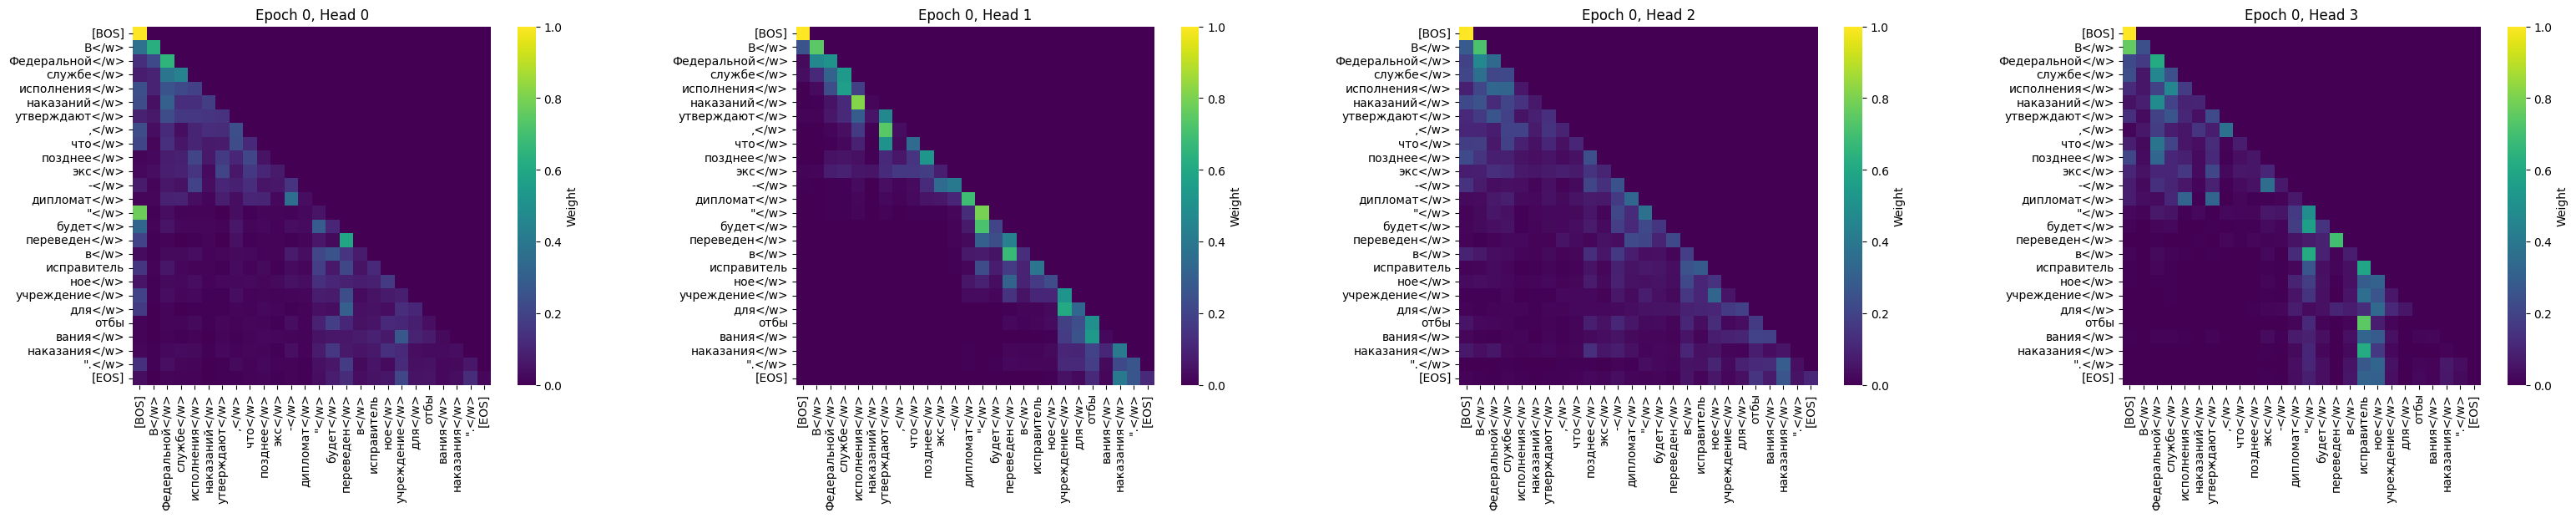

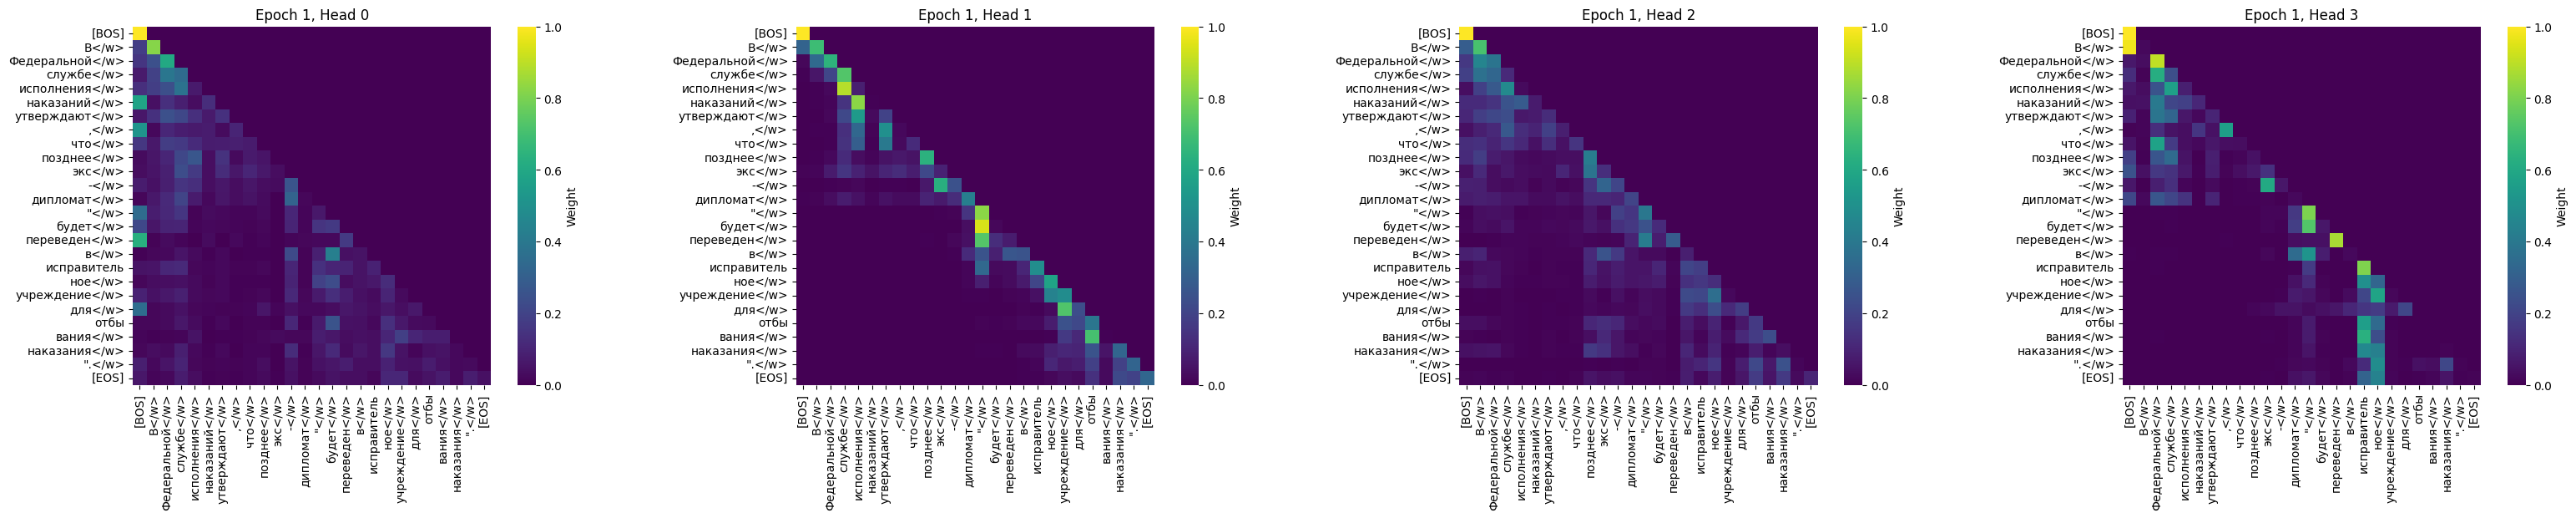

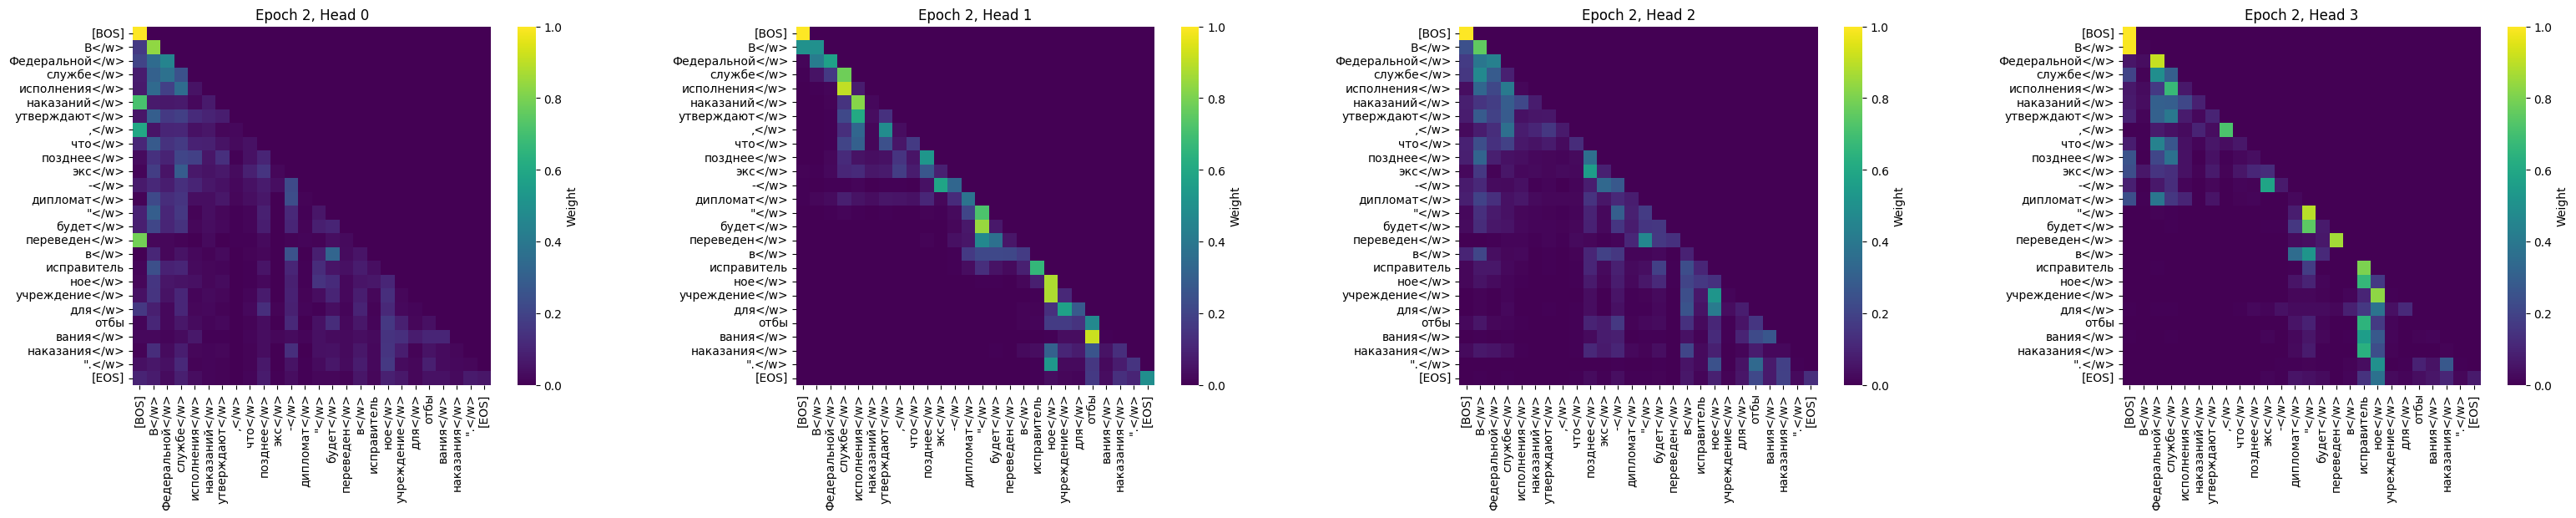

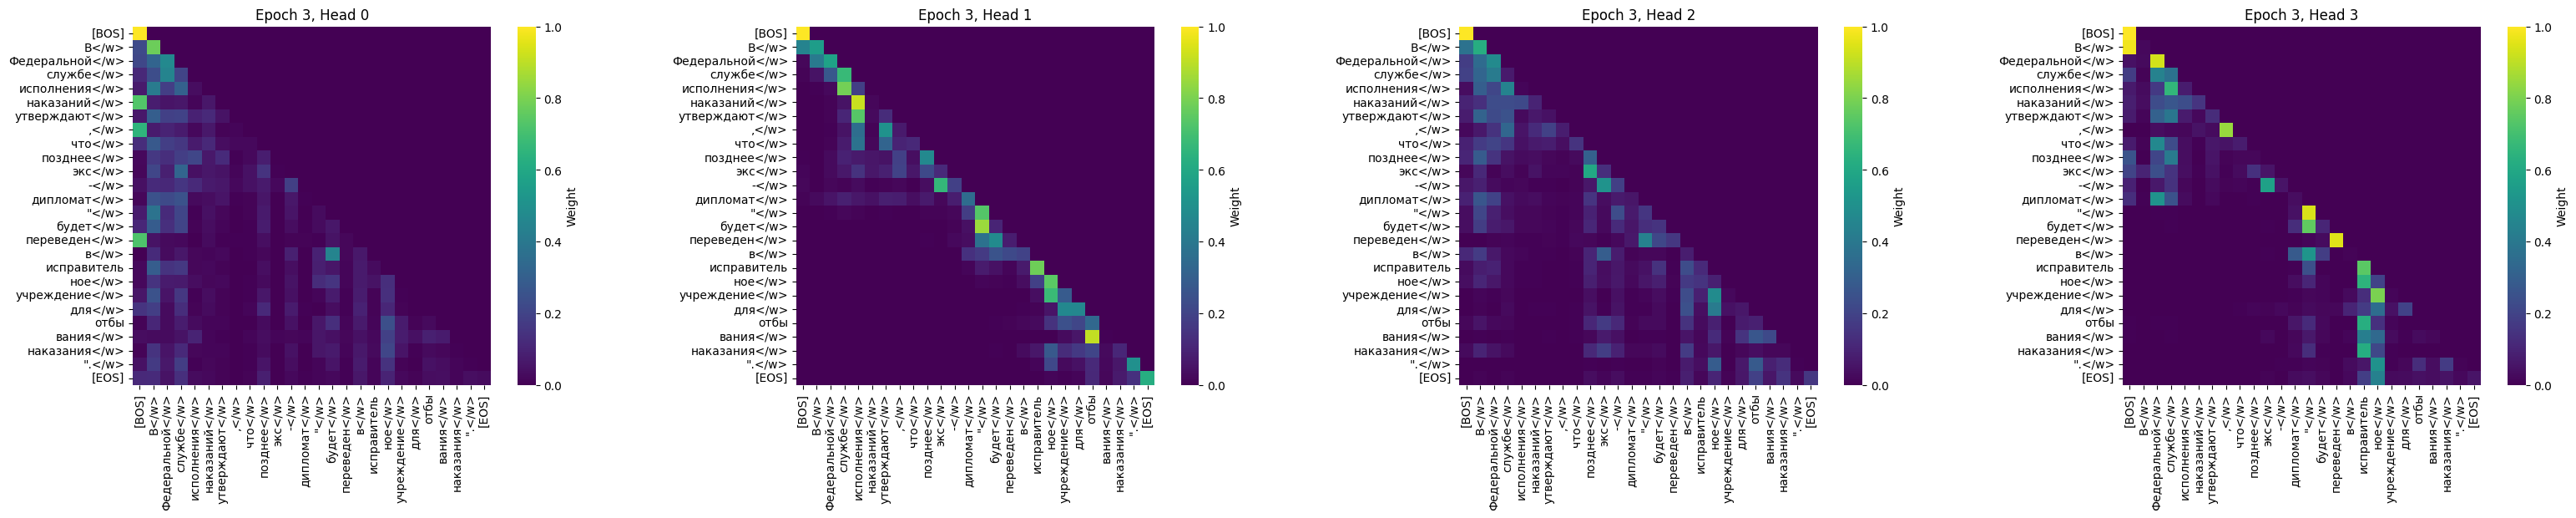

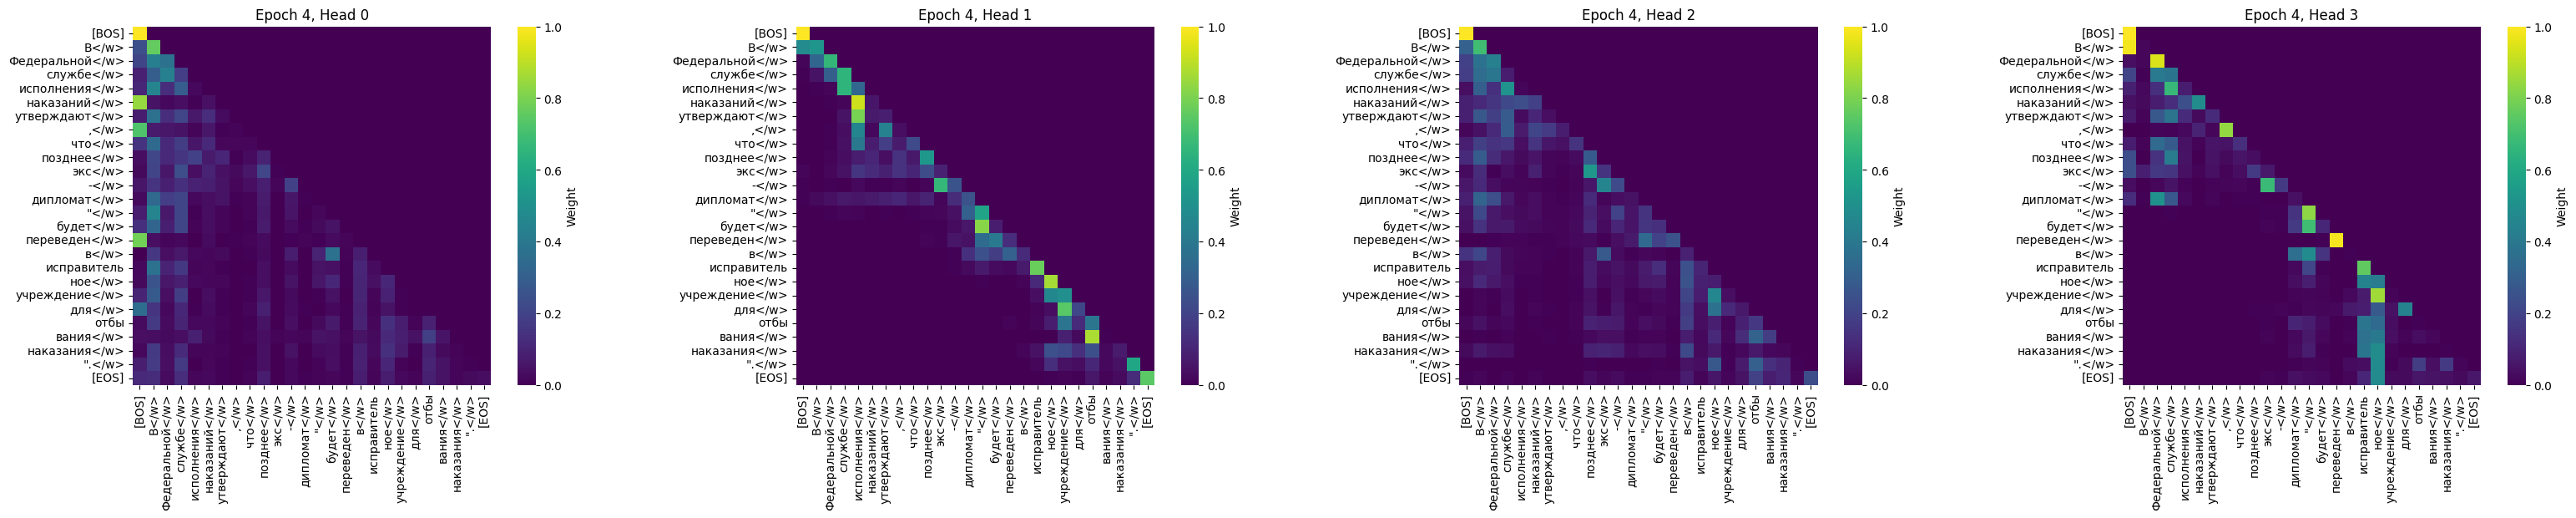

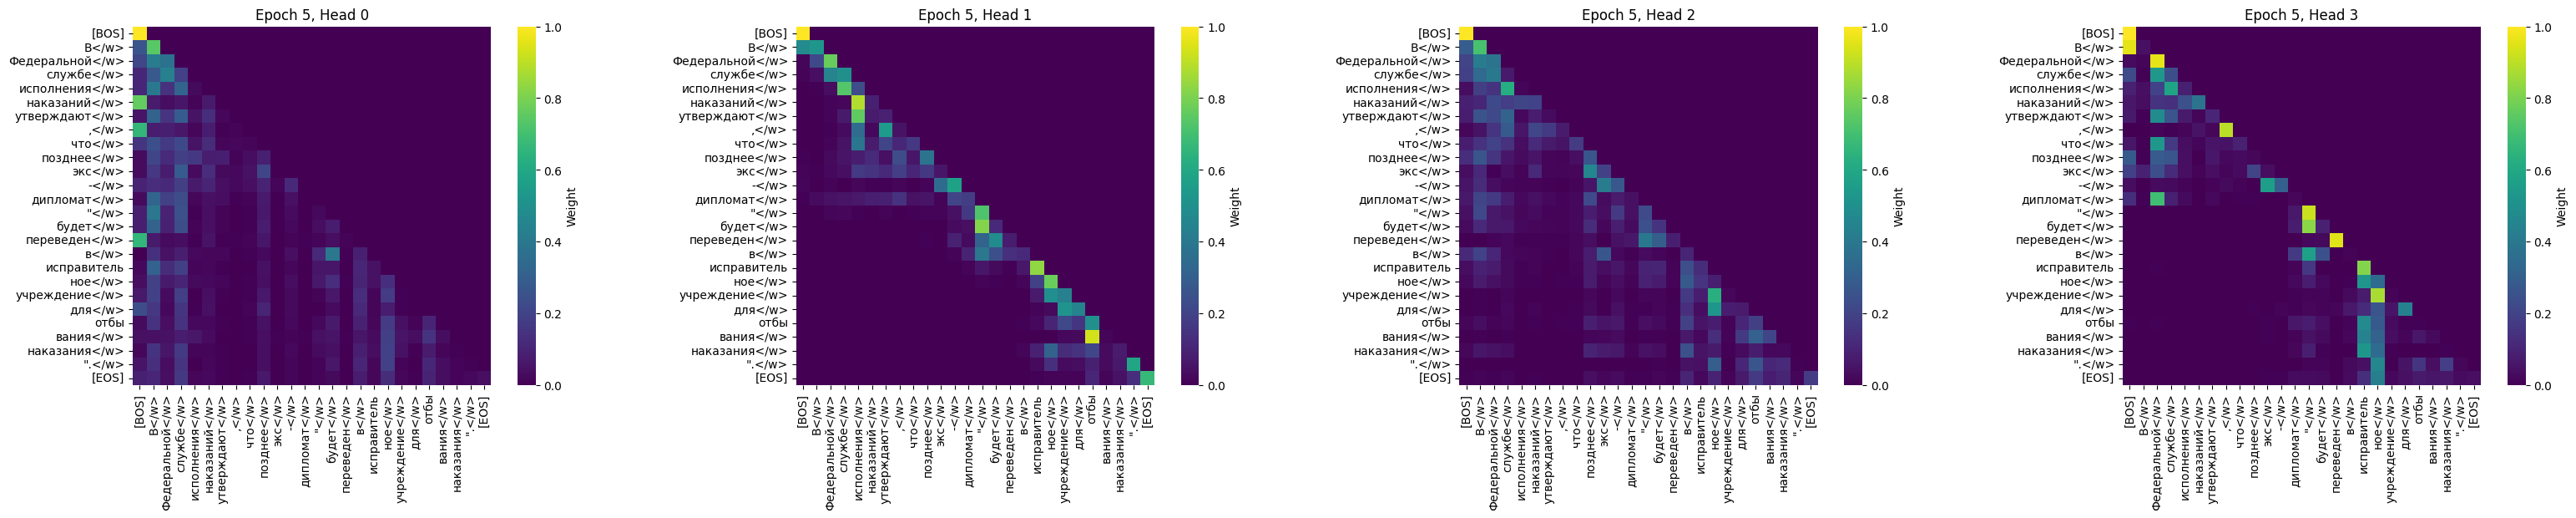

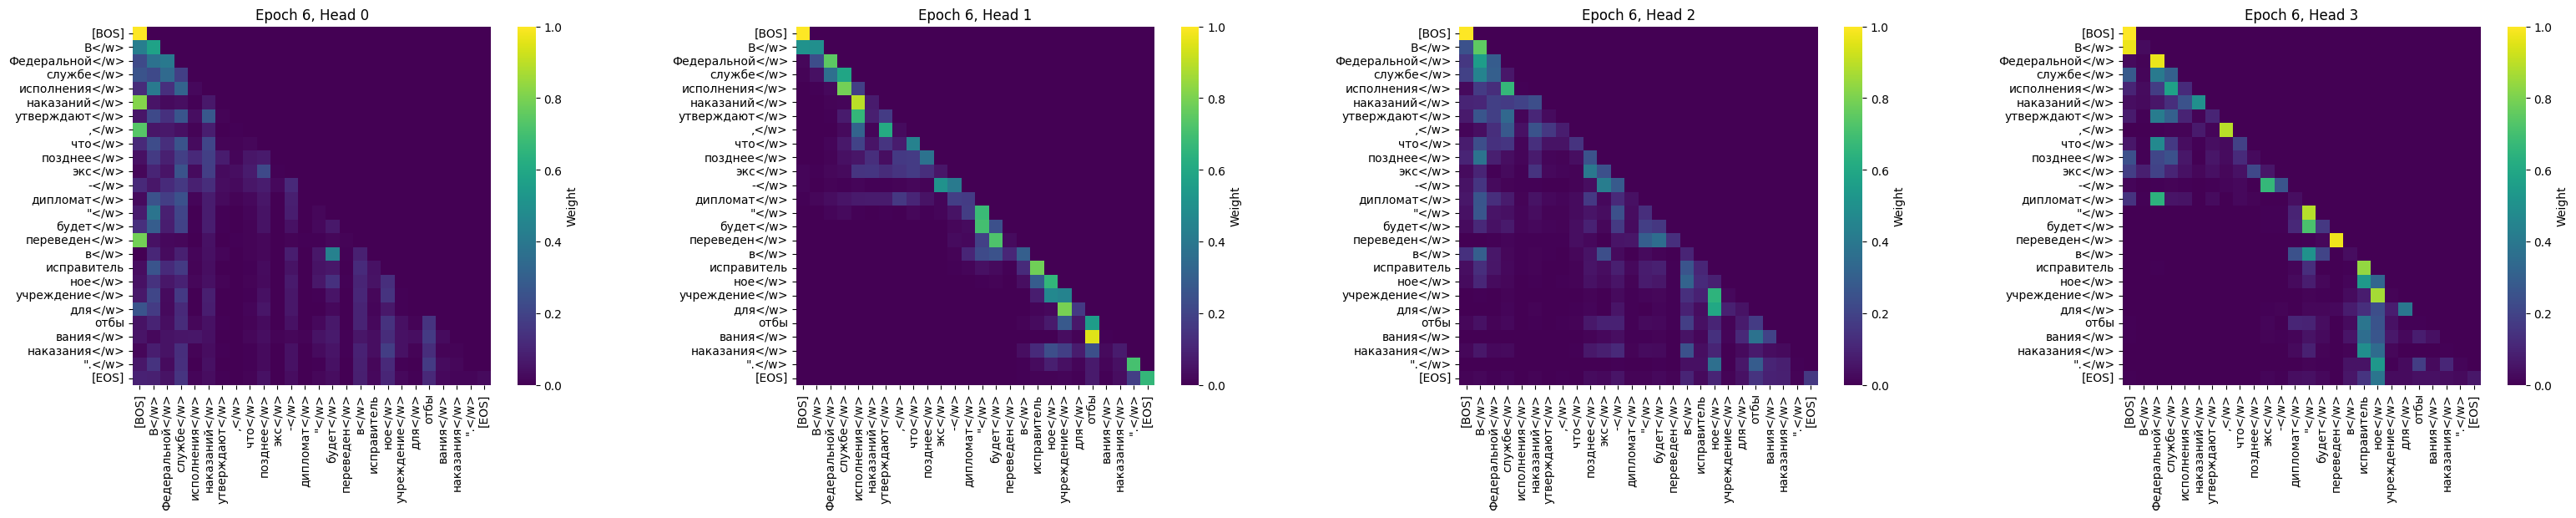

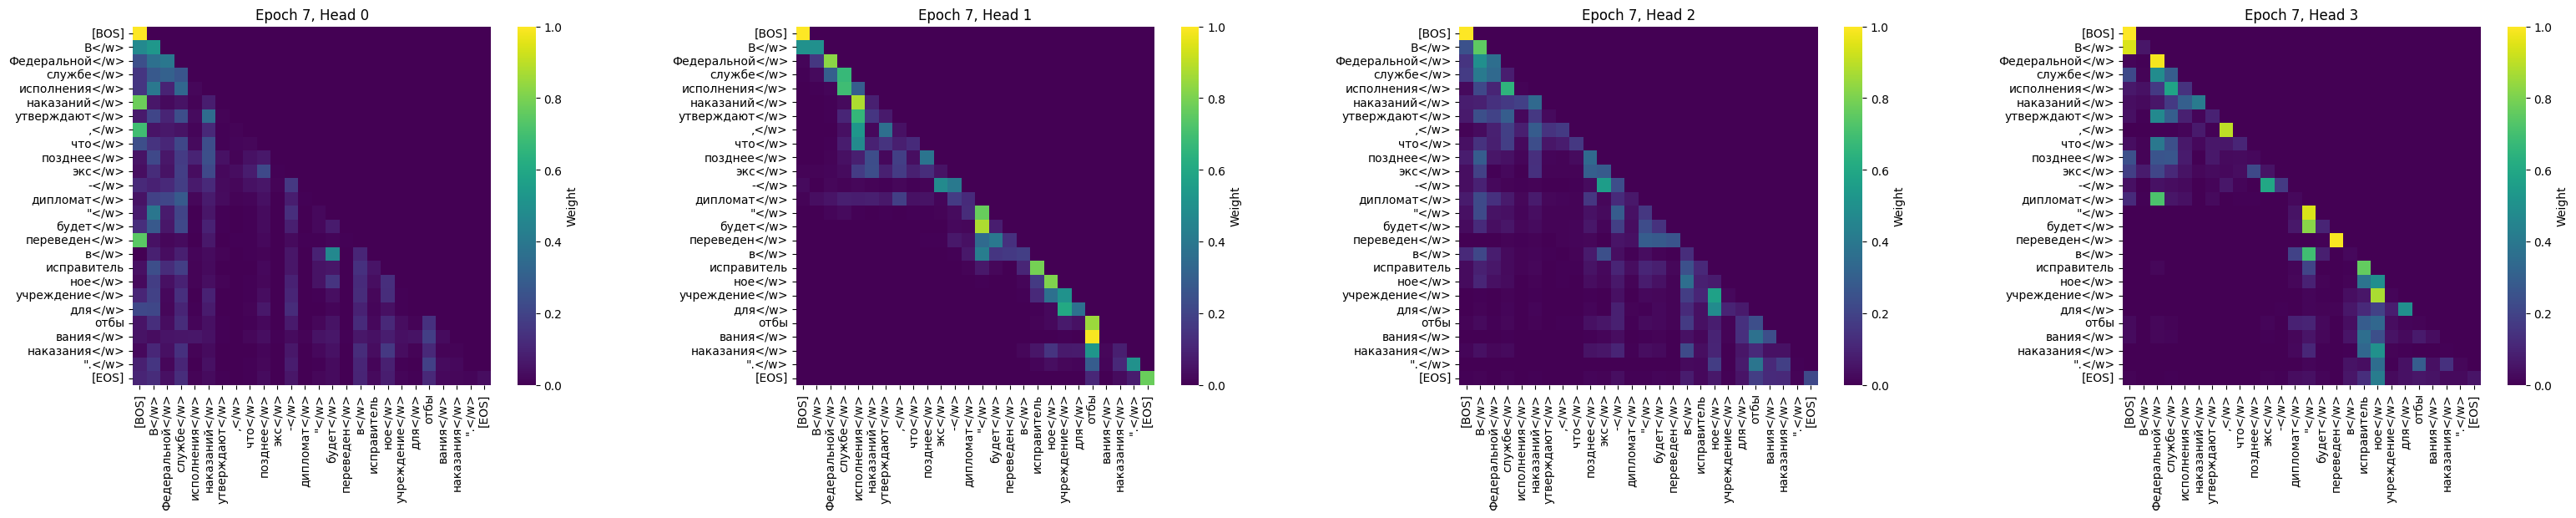

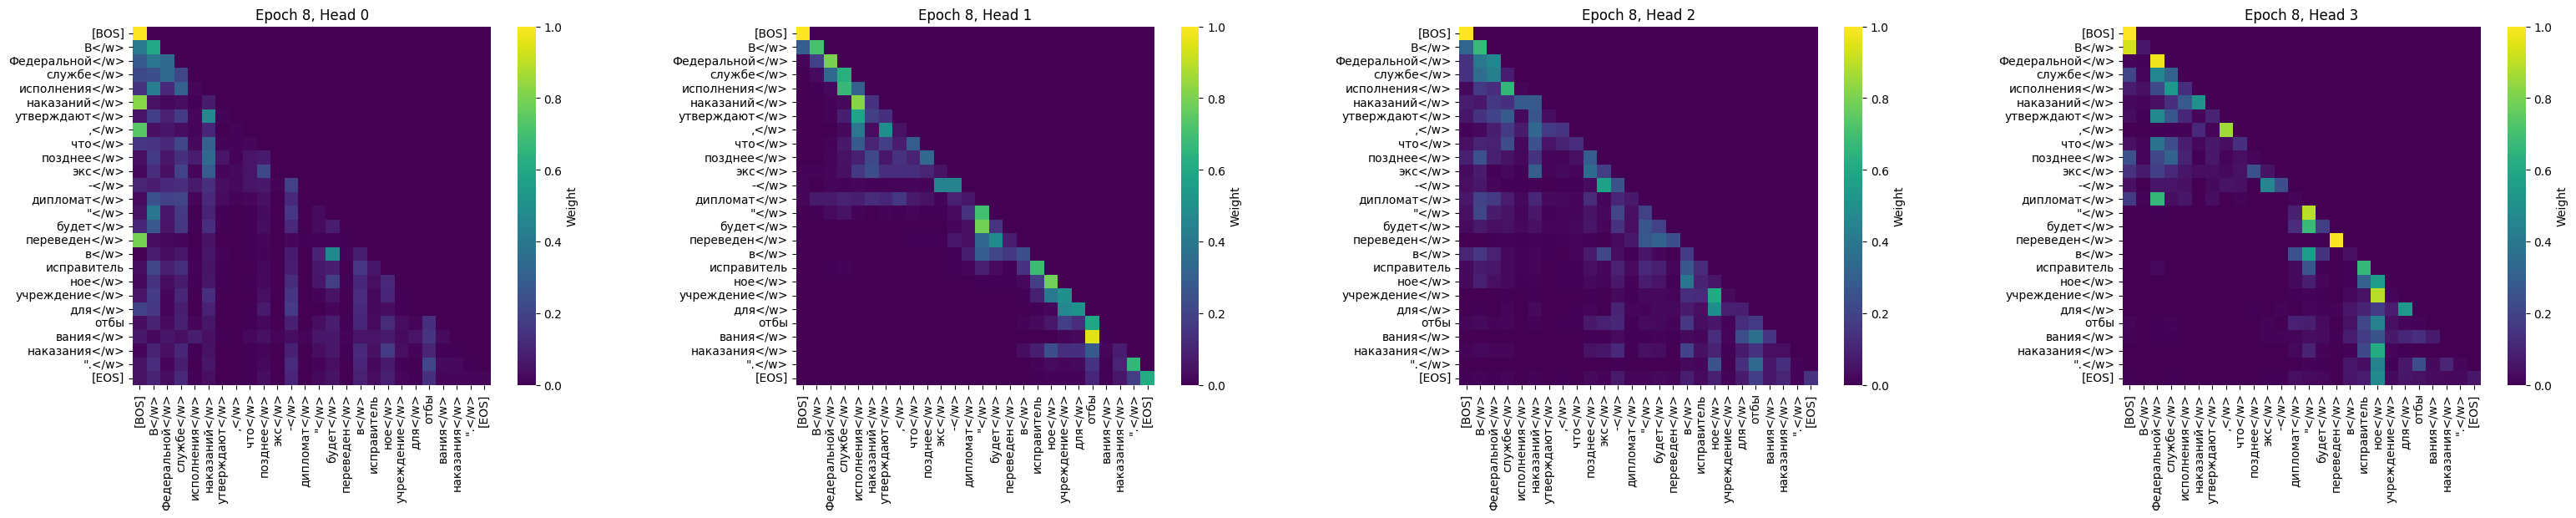

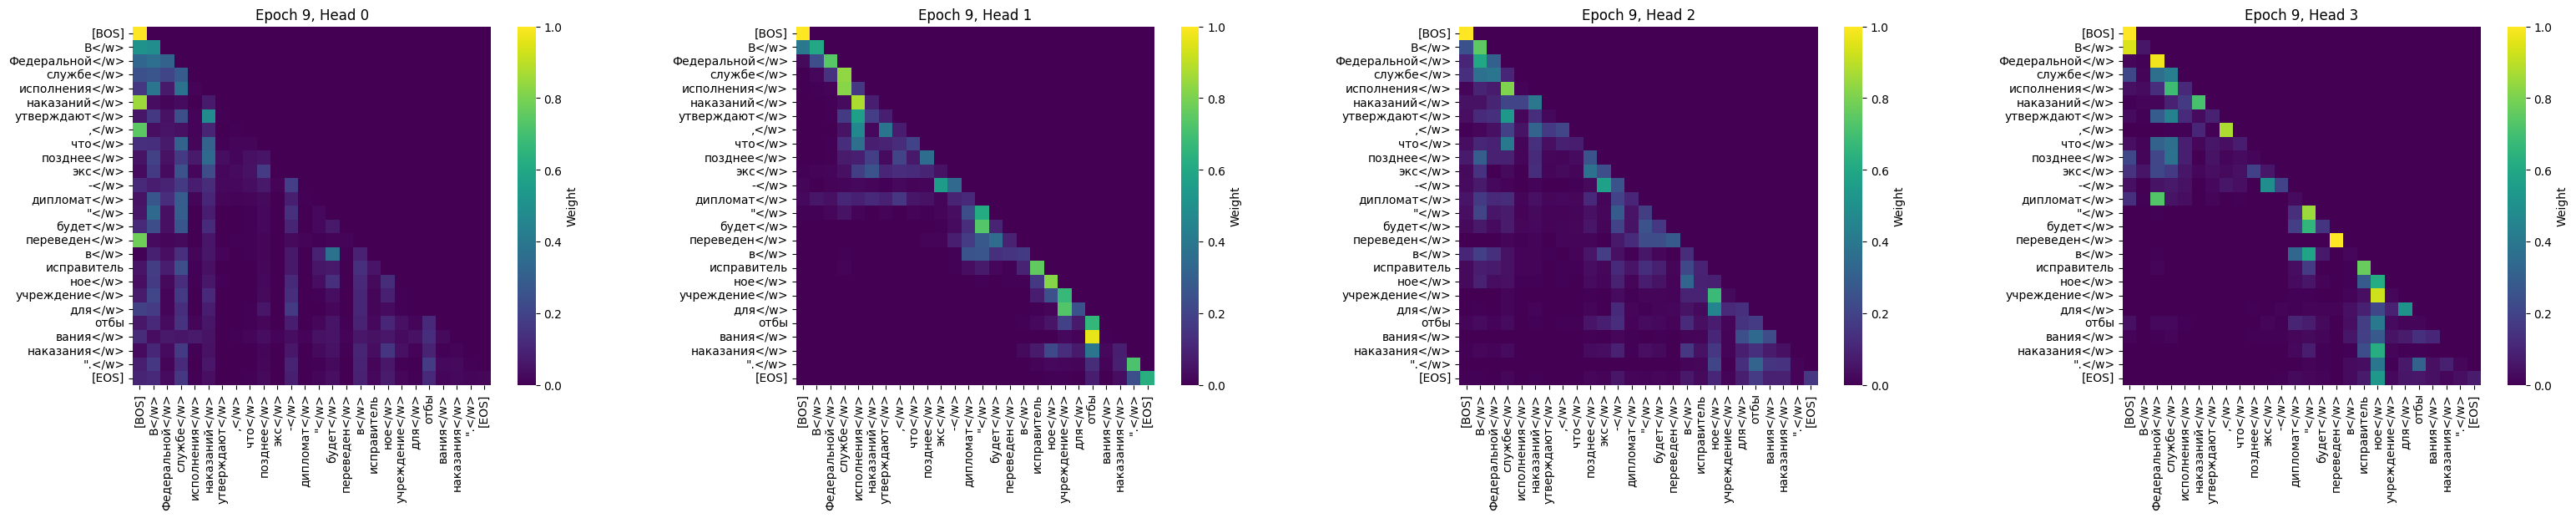

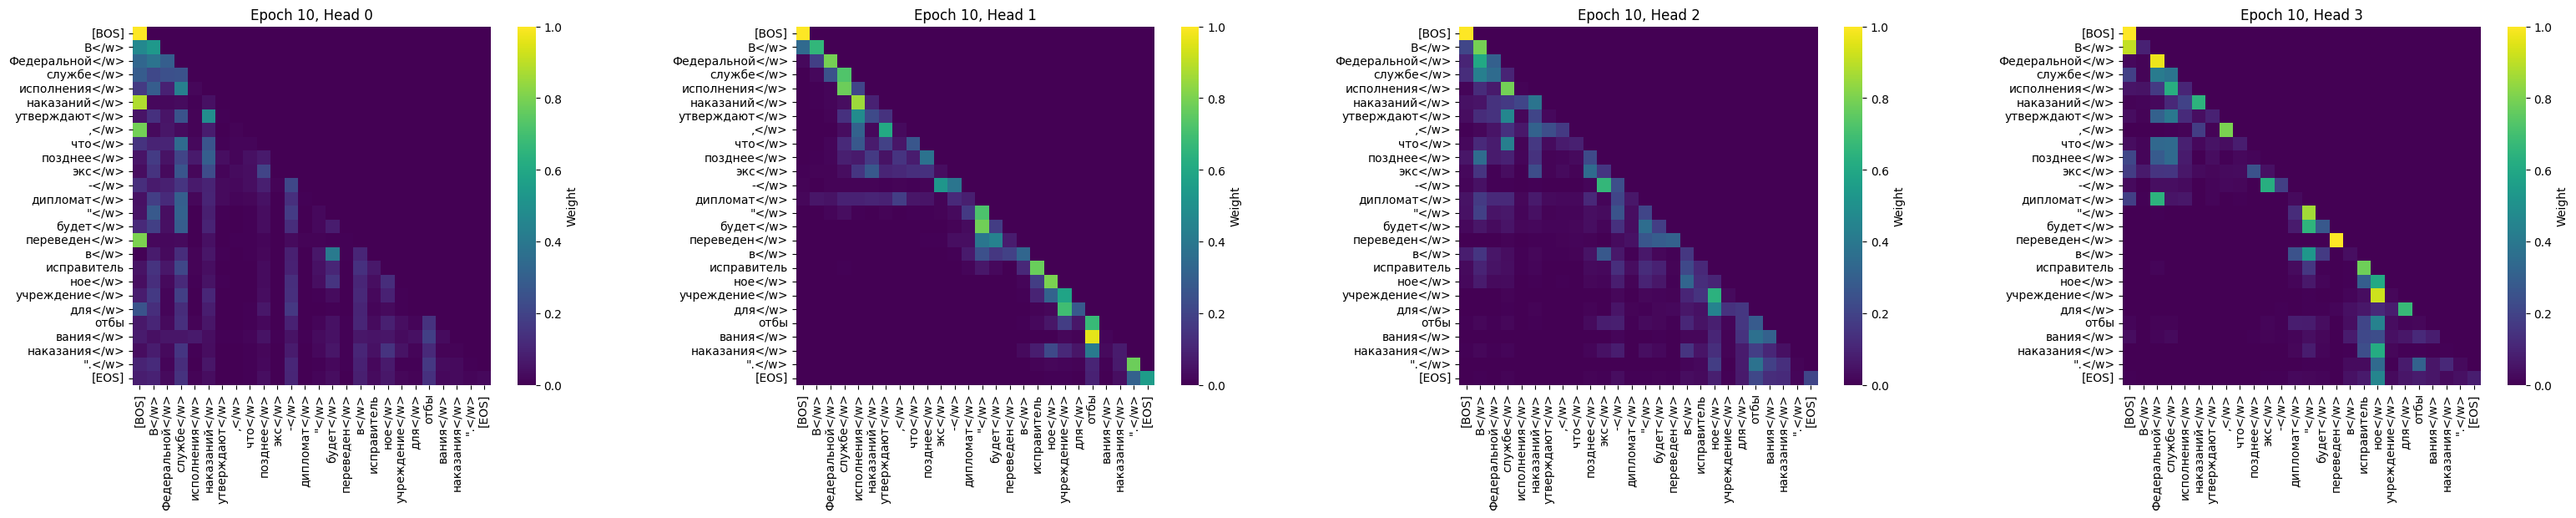

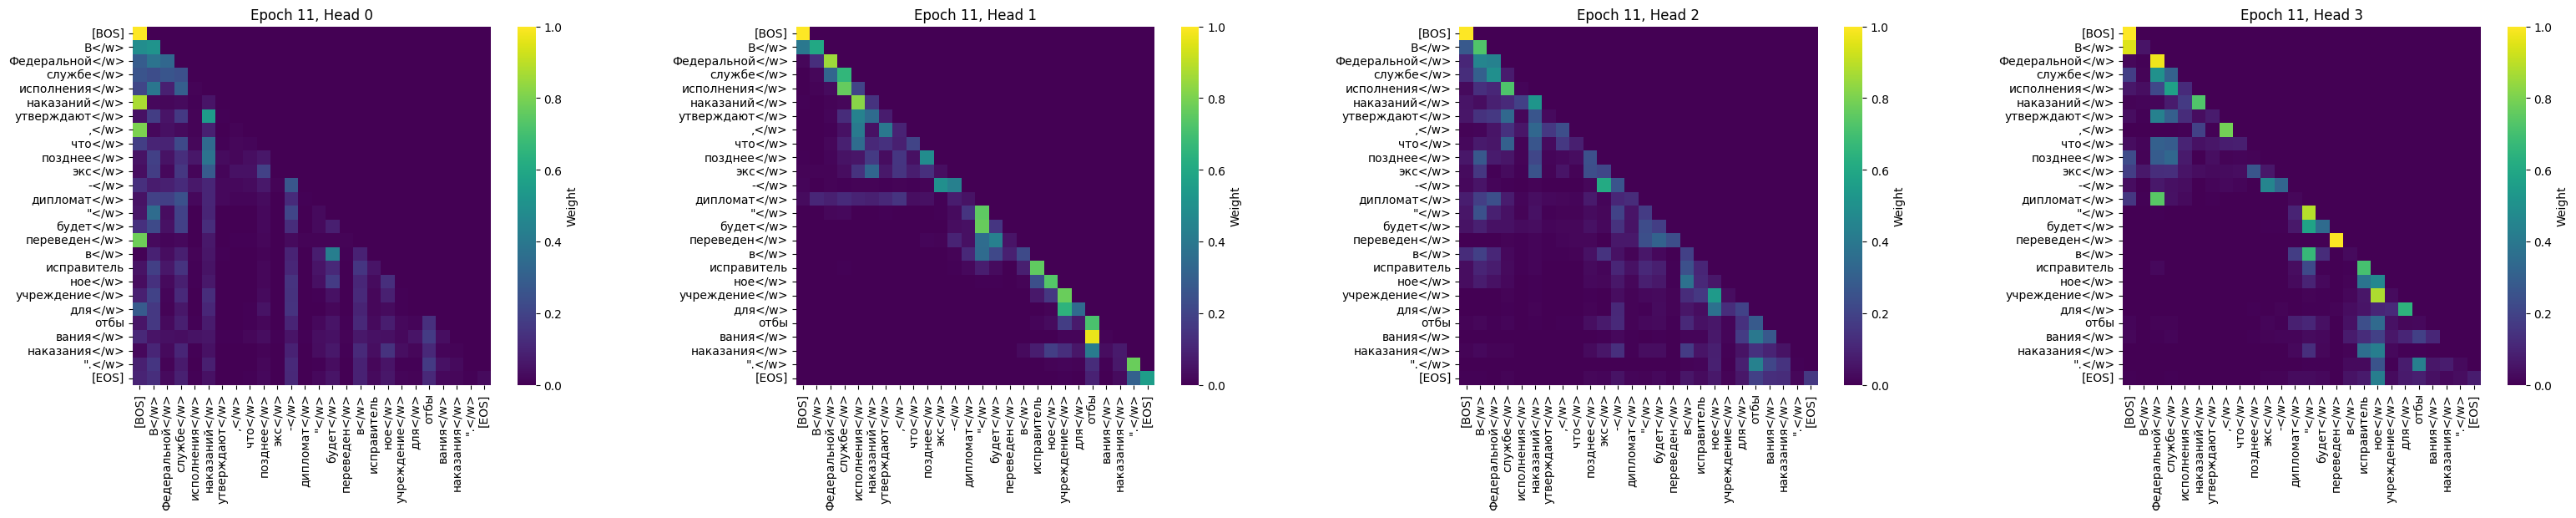

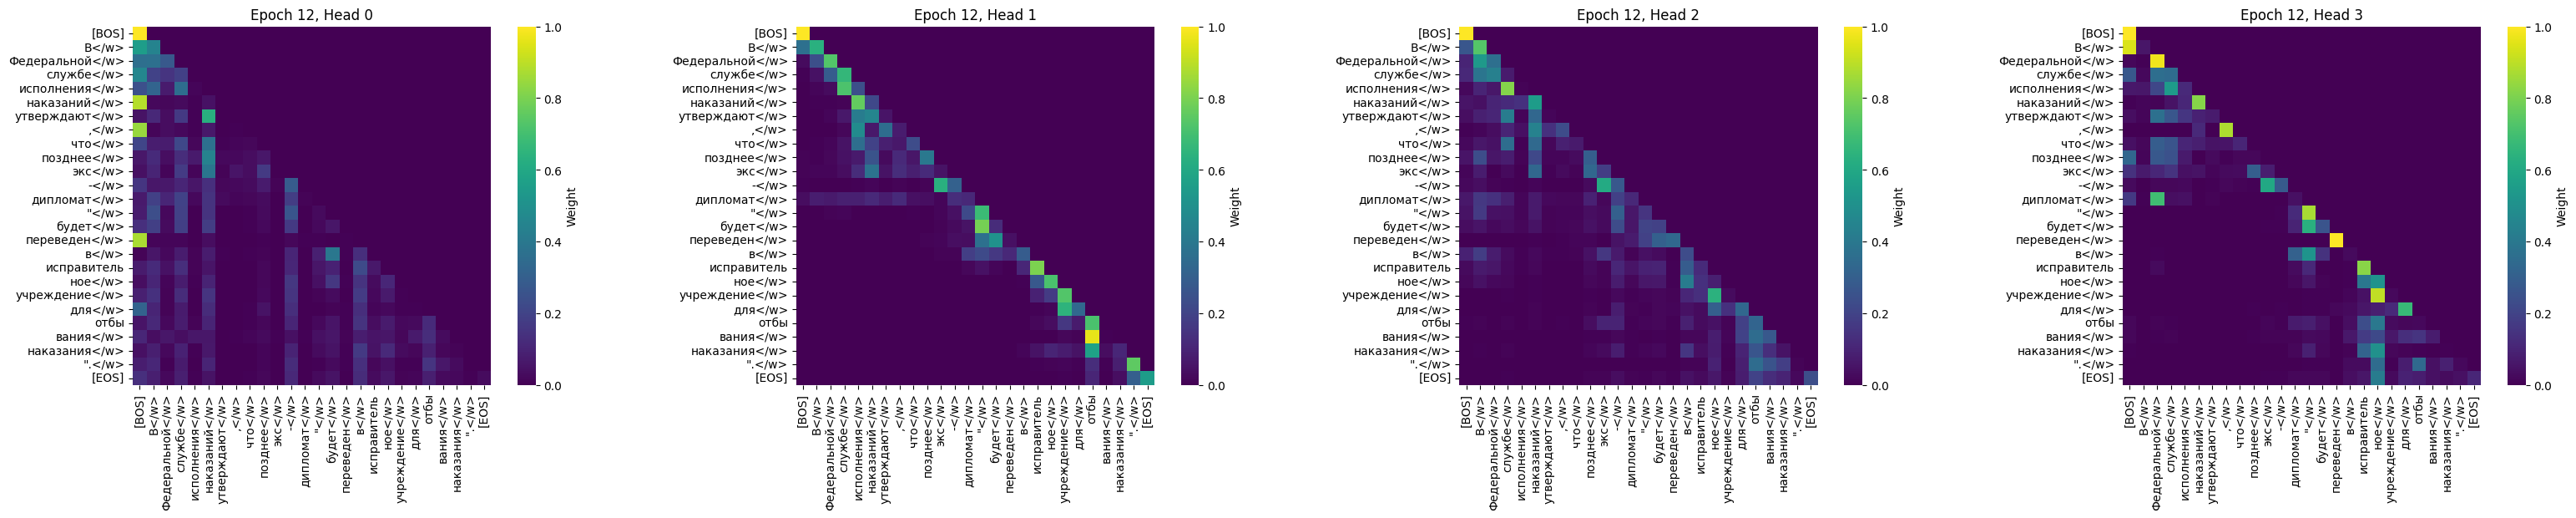

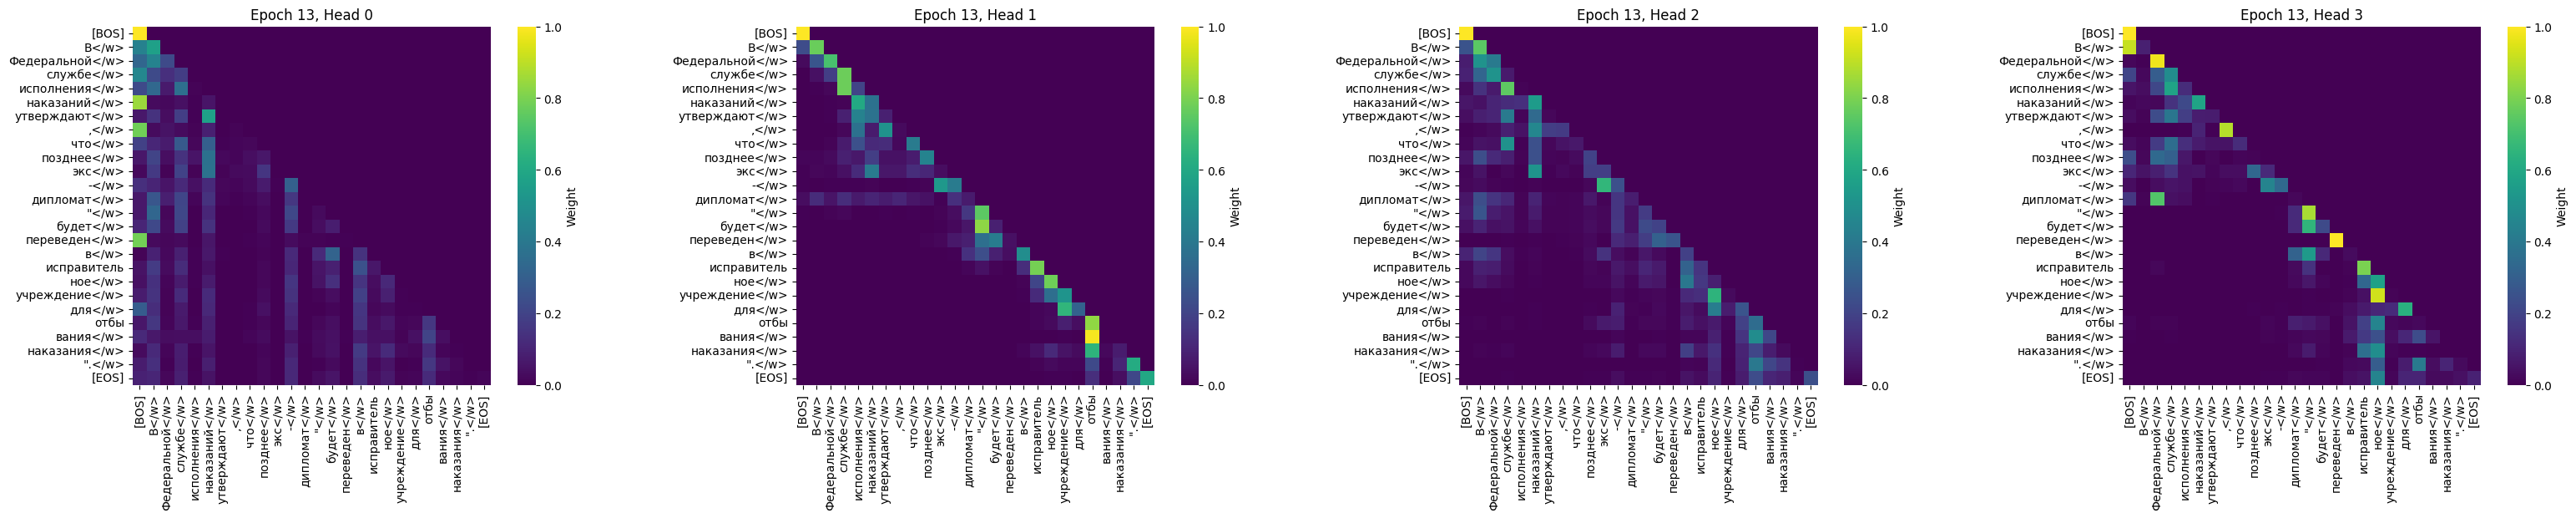

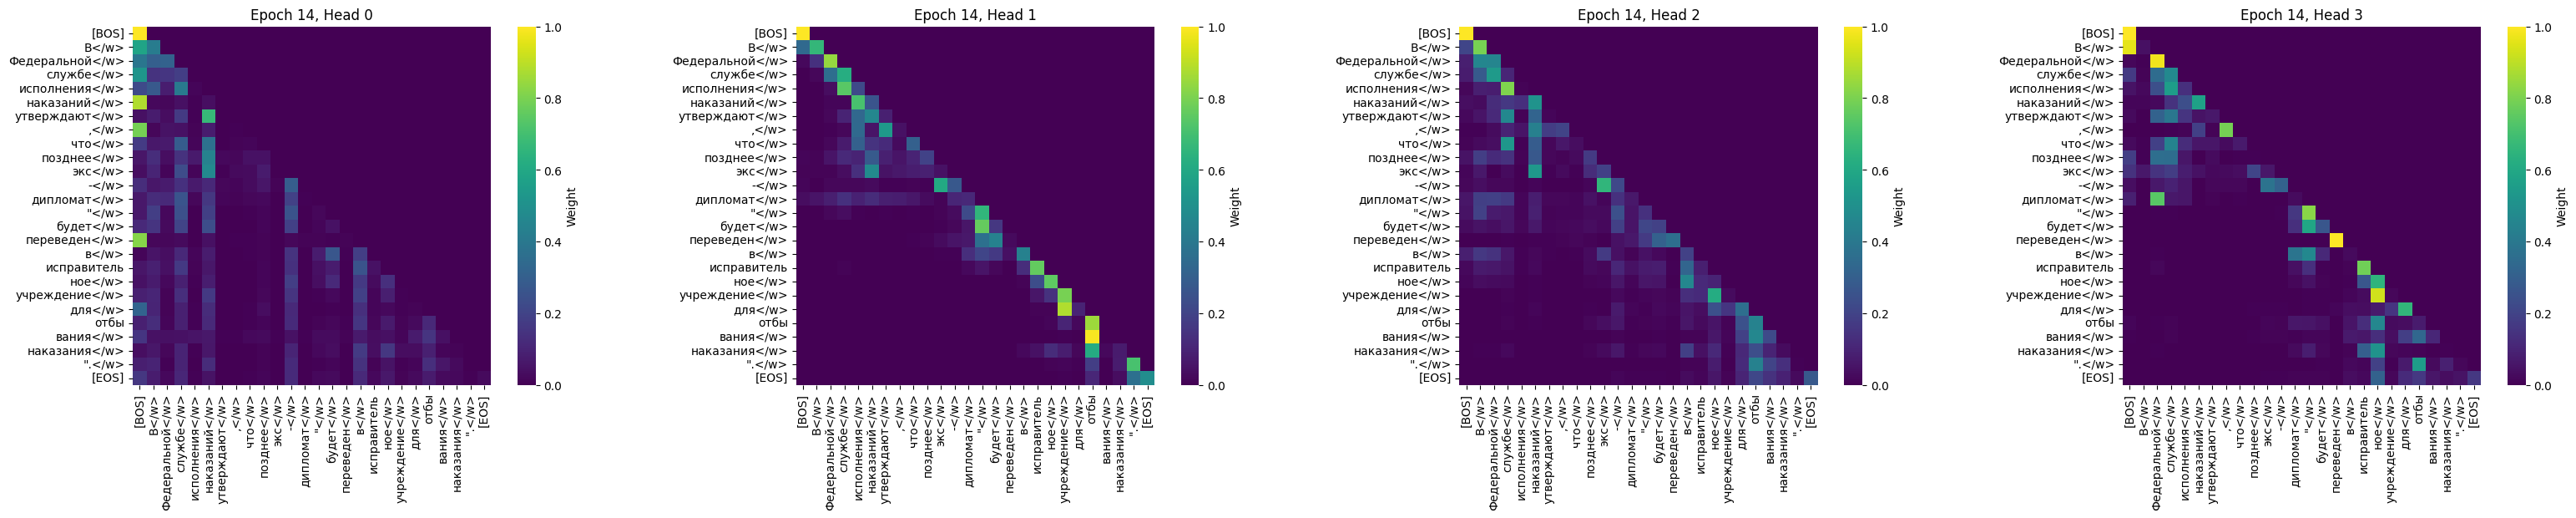

In [92]:
def viz_att(attentions, sentence_idx, epoch):
    sentence_ids = val_set[sentence_idx][0]
    tokens = []
    for i in sentence_ids:
        if tokenizer.id_to_token(i) != '[PAD]':
            tokens.append(tokenizer.id_to_token(i) )

    max_length = attentions[epoch][-1][0].shape[0]
    actual_length = min(len(tokens), max_length)
    tokens = tokens[:len(tokens)]

    fig, axes = plt.subplots(1, 4, figsize=(8 * 4, 6))

    for head_idx in range(4):
        attention_matrix = attentions[epoch][-1][head_idx][:len(tokens), :len(tokens)]

        sns.heatmap(
            attention_matrix,
            cmap='viridis',
            ax=axes[head_idx],
            square=True,
            xticklabels=tokens,
            yticklabels=tokens,
            cbar_kws={"label": "Weight"}
        )
        axes[head_idx].set_title(f'Epoch {epoch}, Head {head_idx}')

    plt.tight_layout()

sentence_idx = 22888
for e in range(15):
    viz_att(attentions_by_epoch, sentence_idx, epoch=e)